# `flarestack` Test Minimization Notebook

## 1. Directory Setup

In [1]:
import logging
logging.basicConfig(level='INFO')

In [2]:
import os
os.environ['FLARESTACK_SCRATCH_DIR']

'/Users/thomasahrens/Desktop/IceCube/flarestack/scratch'

In [3]:
from flarestack.shared import host_server
from flarestack.data.icecube.ic_season import icecube_dataset_dir
print(f'Running at {host_server}, data directory is {icecube_dataset_dir}')

INFO:flarestack.shared:Scratch Directory is: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/input/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/cluster/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/input/pull_corrections/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/cluster/logs/
INFO:flarestack.shared:Fou

Running at None, data directory is /Users/thomasahrens/Desktop/IceCube/flarestack/datasets


In [4]:
from flarestack.shared import fs_scratch_dir
print(f'Scratch directory is {fs_scratch_dir}')

Scratch directory is /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/


## 2. Flarestack Classes

Classes used in $\texttt{flarestack}$'s core functionality (e.g. `flarestack.core.energy_pdf.EnergyPDF`, `flarestack.core.minimisation.MinimisationHandler`, etc) have a class attribute `<class>.subclasses`.  
This is a dictionary with the structure `{<subclass name>: <subclass>}`.  

In [5]:
from flarestack.core.minimisation import MinimisationHandler
MinimisationHandler.subclasses

{'fixed_weights': flarestack.core.minimisation.FixedWeightMinimisationHandler,
 'large_catalogue': flarestack.core.minimisation.LargeCatalogueMinimisationHandler,
 'fit_weights': flarestack.core.minimisation.FitWeightMinimisationHandler,
 'fit_weights_mcmc': flarestack.core.minimisation.FitWeightMCMCMinimisationHandler,
 'fit_weights_hmc': flarestack.core.minimisation.FitWeightHMCMinimisationHandler,
 'flare': flarestack.core.minimisation.FlareMinimisationHandler}

For analyses we only have to pass a dictionary of the subclass names and corresponding parameters.  
To execute use `flarestack.cluster.submitter.Submitter`. This always works locally. For using the cluster, again, if you are running at DESY or WIPAC, you do not have to worry. We got you covered.

In [6]:
from flarestack.cluster.submitter import Submitter
Submitter.submitter_dict

{'local': flarestack.cluster.submitter.LocalSubmitter,
 'DESY': flarestack.cluster.submitter.DESYSubmitter,
 'WIPAC': flarestack.cluster.submitter.WIPACSubmitter}

## 3. Example: Point Source Sensitivity

Let's try to calculate the 10-year point source sensitivity for our test catalogue.  
The input directory (with the analysis dictionaries), the output directory (plots, p-values, etc) and the cache directory (saved trials, etc) will be created accordingly.   
First we have to specify a name for the analysis.

In [7]:
from flarestack.shared import plot_output_dir, name_pickle_output_dir
from glob import glob

In [8]:
min_types = ('fixed', 'fit', 'mcmc', 'hmc')

def name_func(n_sources, gamma, min_type, etc=None):
    """Creates name for output analysis files.
    
    :param n_sources: Number of sources in catalog
    :type n_sources: int
    
    :param gamma: Spectral index
    :type n_sources: float
    
    :param min_type: Minimization method (see MinimisationHandler.subclasses)
    :type n_sources: str
    
    :param etc: Additional simulation/run info
    :type n_sources: str
    
    :return path: Path used as name
    :rtype path: str
    """
    run_no = 1
    
    if min_type not in min_types:
        raise ValueError(f'Provide valid minimizer: {min_types}')
        
    path = f'analyses/{n_sources}source_gamma{gamma}_{min_type}'
    
    if etc is not None:
        path += f'_{etc:s}'
        
    path += f'_run{run_no}'
    
    path_exist = os.path.exists(plot_output_dir(path)) or os.path.exists(name_pickle_output_dir(path))
    
    if path_exist:
        # Automatically covers cases where run_no == (n_sources or gamma)
        glob_path = path.split(f'_run{run_no}')[0]
        # Get all runs with same path
        previous_runs = glob(f'{name_pickle_output_dir(glob_path)}*')
        # Get run numbers for previous runs, convert strings to ints
        run_nums = [int(i.split('run')[1]) for i in previous_runs]
        # Sort run numbers
        run_nums.sort()
        # Get last run number, increase index by 1
        run_no = run_nums[-1] + 1
        path = f'{glob_path}_run{run_no}'
    else:
        # Path DNE, unchanged path (run 1)
        pass
    
    return path

In [9]:
name = name_func(n_sources=2, gamma=2.0, min_type='mcmc', etc='sumscale_trials100_seedtrunc')
name

'analyses/2source_gamma2.0_mcmc_sumscale_trials100_seedtrunc_run1'

Our plot output directories will be:

In [10]:
from flarestack.shared import plot_output_dir, name_pickle_output_dir
plot_output_dir(name), name_pickle_output_dir(name)

('/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/2source_gamma2.0_mcmc_sumscale_trials100_seedtrunc_run1',
 '/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/pickles/analyses/2source_gamma2.0_mcmc_sumscale_trials100_seedtrunc_run1')

Many dataset implementations are available in `flarestack.data`. We will use the PS Tracks v3.2

In [11]:
# from flarestack.data.icecube import ps_v003_p02
from flarestack.data.public import icecube_ps_3_year

We want to inject a steady neutrino signal with a power law spectrum with $\gamma=2.5$. For other Energy or Time PDFs check `flarestack.core.energy_pdf` and `flarestack.core.time_pdf`.   \
This is as straight forward as:

In [12]:
injection_energy = {
    "energy_pdf_name": "power_law",
    "gamma": 2.0
}

injection_time = {
    "time_pdf_name": "steady"
}

inj_kwargs = {
    "injection_energy_pdf": injection_energy,
    "injection_sig_time_pdf": injection_time
}

We are looking for a steady signal with a power law spectrum. 
We assume the background to be constant in time.  
We want to use the "standard" point source likelihood. More likelihood implementations in `flarestack.core.llh`

In [13]:
llh_time = {
    "time_pdf_name": "steady"
}

llh_energy = {
    "energy_pdf_name": "power_law",
}

llh_time_bkg = {
    "time_pdf_name": "steady"
}

llh_kwargs = {
    "llh_name": "standard",
    "llh_energy_pdf": llh_energy,
    "llh_sig_time_pdf": llh_time,
    "llh_bkg_time_pdf": llh_time_bkg
}

We need a source catalogue. This catalogue will be a numpy array stored as a `.npy` file and we only pass the filename.   
For point sources the is a uitility function to generate dummy sources.

In [14]:
# from flarestack.utils.prepare_catalogue import ps_catalogue_name
import numpy as np

sindec = 0.5
catalogue_path = "/Users/thomasahrens/Desktop/IceCube/sn-search/catalog/test_catalogue_2.npy"
print(f'your catalogue is located at {catalogue_path}')
catalogue = np.load(catalogue_path)
catalogue

your catalogue is located at /Users/thomasahrens/Desktop/IceCube/sn-search/catalog/test_catalogue_2.npy


array([(0.19872028, -0.24886844, 1., 1., nan, nan, nan, 2.04324986e+13, b'ASASSN-14il'),
       (3.67889954, -0.67152028, 1., 1., nan, nan, nan, 1.64885347e+13, b'ASASSN-15ab')],
      dtype=[('ra_rad', '<f8'), ('dec_rad', '<f8'), ('base_weight', '<f8'), ('injection_weight_modifier', '<f8'), ('ref_time_mjd', '<f8'), ('start_time_mjd', '<f8'), ('end_time_mjd', '<f8'), ('distance_mpc', '<f8'), ('source_name', 'S30')])

Now we make a guess for our sensitivity.   
Note: $\texttt{flarestack}$ is using its own scale factor $k$.

In [15]:
from flarestack.shared import flux_to_k, k_to_flux
flux_to_k(1), flux_to_k(1e-9)

(999999999.9999999, 1.0)

Here we know where the sensitivity should be. Because the analysis has been done before.

In [16]:
logging.basicConfig(level='ERROR')
from flarestack.icecube_utils.reference_sensitivity import reference_sensitivity
scale = flux_to_k(reference_sensitivity(np.sin(catalogue['dec_rad']))) * 3
scale

array([ 6.24859081, 24.92108471])

Now we just have to put all the info into one dictionary to pass to the `MinimisationHandler`

In [17]:
mh_dict = {
    "name": name,                                           # unique name for the analysis
    "mh_name": "fit_weights_mcmc",                          # name of the MinimisationHandler subcalss
    "dataset": icecube_ps_3_year.get_seasons("IC86-2012"),  # the neutrino dataset
    "catalogue": catalogue_path,                            # path to the .npy catalogue file
    "inj_dict": inj_kwargs,                                 # info for the Injector
    "llh_dict": llh_kwargs,                                 # info for the LLH
    "scale": np.sum(scale),                                 # a guess for the sensitivity scale
    "n_trials": 100,                                        # number of trials to run (background trials will be run ten times this number!)
    "n_steps": 10,                                          # number of steps when injecting signal
    "allow_extrapolated_sensitivity": True                  # allow extrapolation in the sensitivity calculation (here we do because we only run very few trials)
}

To execute the analysis we defined above we create a submitter instance

In [18]:
submitter = Submitter.get_submitter(
    mh_dict=mh_dict,                         # the analysis info
    use_cluster=False,                       # run it on the cluster if True
    n_cpu=7,                                # number of LOCAL CPUs to use, NOTE: the number of cluster CPUs has to be specified in the cluster_kwargs!
    do_sensitivity_scale_estimation=False,   # make a guess of the sensitivity scale, for options check flarestack.cluster.submitter
    remove_old_results=True,                 # if you are running the analysis again and something changed, maybe you want to remove old trials?
#   **cluster_kwargs                         # keyword arguments used when running the cluster, This depends on the cluster obviously
)

print(submitter)


----- Submitter for analyses/2source_gamma2.0_mcmc_sumscale_trials100_seedtrunc_run1 -----
not using cluster 
using 7 CPUs locally
job-id: None 
no scale estimation 



Energise ......

In [19]:
# %prun -T prun.txt submitter.analyse()
submitter.analyse()

INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.injector:Initialising Injector for IC86-2012
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.multiprocess_wrapper:Added 1900 trials to queue. Now processing.
INFO:flarestack.core.multiprocess_wrapper:1900 tasks remaining.
/Users/thomasahrens/Desktop/IceCube/flarestack/flarestack/core/llh.py:912: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must speci

INFO:flarestack.core.multiprocess_wrapper:1356 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:1348 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:1340 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:1333 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:1323 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:1315 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:1307 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:1298 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:1291 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:1283 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:1276 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:1267 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:1258 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:1251 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:1242 tasks remaining.
INFO:flarestack.core.multiprocess_wrappe

INFO:flarestack.core.multiprocess_wrapper:527 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:522 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:516 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:511 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:508 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:502 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:496 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:493 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:488 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:482 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:478 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:474 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:467 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:461 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:459 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:453 tasks rem

To get the results we use the `ResultsHandler()`. This will also create some plots like the sensitivity fit, bias plots, etc. in the plot directory. If `OverfluctuationError`, set `do_sens=False` and `do_disc=False` in `ResultsHandler()` object.

```do_sens=False, do_disc=False```

In [20]:
from flarestack.core.results import ResultsHandler
results_handler = ResultsHandler(submitter.mh_dict)
# results_handler.__dict__

INFO:flarestack.core.results:Saving bias plot to /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/2source_gamma2.0_mcmc_sumscale_trials100_seedtrunc_run1/bias_n_s (b'ASASSN-15ab').pdf
INFO:flarestack.core.results:Saving bias plot to /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/2source_gamma2.0_mcmc_sumscale_trials100_seedtrunc_run1/bias_n_s (b'ASASSN-14il').pdf
INFO:flarestack.core.results:Saving bias plot to /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/2source_gamma2.0_mcmc_sumscale_trials100_seedtrunc_run1/bias_gamma.pdf
INFO:flarestack.core.results:Fraction of overfluctuations is 0.50 above -0.74 (N_trials=1000) (Scale=0)
INFO:flarestack.core.results:Fraction of overfluctuations is 0.67 above -0.74 (N_trials=100) (Scale=3.463)
INFO:flarestack.core.results:Fraction of overfluctuations is 0.68 above -0.74 (N_trials=100) (Scale=6.927)
INFO:flare

In [21]:
# Move "prun.txt" profiler file to output dir
# os.rename("prun.txt", os.path.join(plot_output_dir(name), "prun.txt"))

In [22]:
print(fr'sensitivity flux: {results_handler.sensitivity:.2e} +{results_handler.sensitivity_err[1]}  -{results_handler.sensitivity_err[0]}')
print(f'reference: {reference_sensitivity(sindec)[0]}')
print(fr'sensitivity n_s: {results_handler.sensitivity * results_handler.flux_to_ns:.2e} +{results_handler.sensitivity_err[1] * results_handler.flux_to_ns}  -{results_handler.sensitivity_err[0] * results_handler.flux_to_ns}')

sensitivity flux: 2.12e-08 +5.9502209528311154e-09  -3.810031537879675e-09
reference: 5.770894709671131e-10
sensitivity n_s: 3.07e+00 +0.8620249994423631  -0.5519698277344511


### MCMC seed values

In [ ]:
from glob import glob
import pickle

In [ ]:
path_to_pickles = os.path.join(name_pickle_output_dir(name), 'merged')
pickles = glob(os.path.join(path_to_pickles, '*'))

ns_14il = []
ns_15ab = []
ns_15hs = []
ns_15ik = []
ns_15nx = []
gamma_data = []

for pkl in pickles:
    pickle_path = pkl

    with open(pickle_path, 'rb') as file:
        pickle_data = pickle.load(file)

    for key, data in pickle_data['Parameters'].items():
        if "n_s (b'ASASSN-14il')" in key:
            ns_14il.append(data)
        if "n_s (b'ASASSN-15ab')" in key:
            ns_15ab.append(data)
        if "n_s (b'ASASSN-15hs')" in key:
            ns_15hs.append(data)
        if "n_s (b'ASASSN-15ik')" in key:
            ns_15ik.append(data)
        if "n_s (b'ASASSN-15nx')" in key:
            ns_15nx.append(data)
        if "gamma" in key:
            gamma_data.append(data)

ns_14il = np.array(sum(ns_14il, []))
ns_15ab = np.array(sum(ns_15ab, []))
ns_15hs = np.array(sum(ns_15hs, []))
ns_15ik = np.array(sum(ns_15ik, []))
ns_15nx = np.array(sum(ns_15nx, []))
gamma_data = np.array(sum(gamma_data, []))

mu_14il = np.mean(ns_14il)
std_14il = np.std(ns_14il)

mu_15ab = np.mean(ns_15ab)
std_15ab = np.std(ns_15ab)

mu_15hs = np.mean(ns_15hs)
std_15hs = np.std(ns_15hs)

mu_15ik = np.mean(ns_15ik)
std_15ik = np.std(ns_15ik)

mu_15nx = np.mean(ns_15nx)
std_15nx = np.std(ns_15nx)

mu_gamma = np.mean(gamma_data)
std_gamma = np.std(gamma_data)


print(f"mu_14il={mu_14il:0.4f} std_14il={std_14il:0.4f}")
print(f"mu_15ab={mu_15ab:0.4f} std_15ab={std_15ab:0.4f}")
print(f"mu_15hs={mu_15hs:0.4f} std_15hs={std_15hs:0.4f}")
print(f"mu_15ik={mu_15ik:0.4f} std_15ik={std_15ik:0.4f}")
print(f"mu_15nx={mu_15nx:0.4f} std_15nx={std_15nx:0.4f}")
print(f"mu_gamma={mu_gamma:0.4f} std_gamma={std_gamma:0.4f}")

In [ ]:
def means_and_dev(name):
    """Calculates mean and standard deviation from `fit_weights` minimizer
    to then be input into `fit_weights_mcmc` minimizer.
    
    :param name: Analysis run name
    :type name: str
    
    :return mu: List of average parameter (n_s, gamma) values
    :rtype mu: list
    
    :return std: List of parameter (n_s, gamma) standard deviations
    :rtype std: list
    """
    path_to_pickles = os.path.join(name_pickle_output_dir(name), 'merged')
    pickles = glob(os.path.join(path_to_pickles, '*'))
    file_num = 0

    for pkl in pickles:
        pickle_path = pkl

        with open(pickle_path, 'rb') as file:
            pickle_data = pickle.load(file)

        if file_num == 0:
            key_arrays = {key:[] for key in pickle_data['Parameters'].keys()}

        for key, data in pickle_data['Parameters'].items():
                key_arrays[key].append(data)

        file_num += 1
        
    mu = []
    std = []

    for key, data in key_arrays.items():
        key_arrays[key] = np.array(sum(key_arrays[key], []))
        mu.append(float(f'{np.mean(key_arrays[key]):0.4f}'))
        std.append(float(f'{np.std(key_arrays[key]):0.4f}'))

    print(f"mu = {mu}")
    print(f"std = {std}")

In [ ]:
means_and_dev(name)

## 4. MCMC Analysis Plots

### Corner Plot

In [23]:
import pickle
import corner
import matplotlib.pyplot as plt

In [24]:
# Path to MCMC pickle directory
mcmc_pickle_path = os.path.join(name_pickle_output_dir(name), 'chains.pkl')

with open(mcmc_pickle_path, 'rb') as file:
    mcmc_pickle = pickle.load(file)
    
mcmc_pickle.shape

(6000, 20, 3)

In [25]:
# Number of dimensions
ndim = len(catalogue) + 1

# Reshape MCMC chains
mcmc_chains = mcmc_pickle[:,...].reshape((-1,ndim))

mcmc_chains.shape

(120000, 3)

In [26]:
# Get source names for labels
labels = []

for source in range(len(catalogue)):
    label = catalogue[source]['source_name'].decode()
    labels.append('n_s: ' + label)

labels.append('gamma')

corner_labels = [x for x in labels]
corner_labels

['n_s: ASASSN-14il', 'n_s: ASASSN-15ab', 'gamma']

In [27]:
# Get truth values
truths = np.append(scale / 3, injection_energy['gamma'])
truths

array([2.0828636 , 8.30702824, 2.        ])

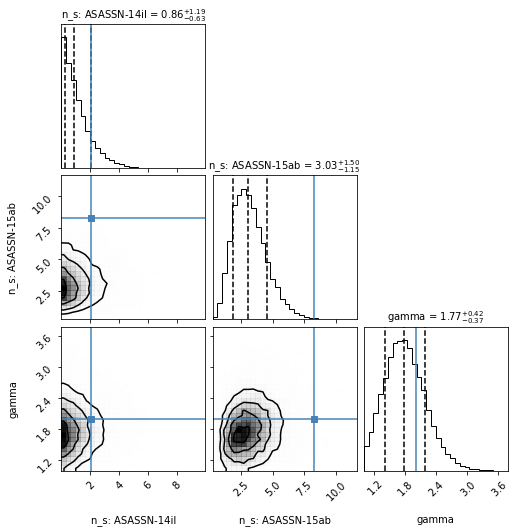

In [28]:
# Corner plot with burn in
fig = corner.corner(mcmc_chains,
                    labels=corner_labels,
                    quantiles=[0.16, 0.5, 0.84],
                    truths=truths,
                    use_math_text=True,
                    show_titles=True, 
                    title_kwargs={"fontsize": 10},
                    plot_datapoints=False,
                    bins=30)

### Walker Steps

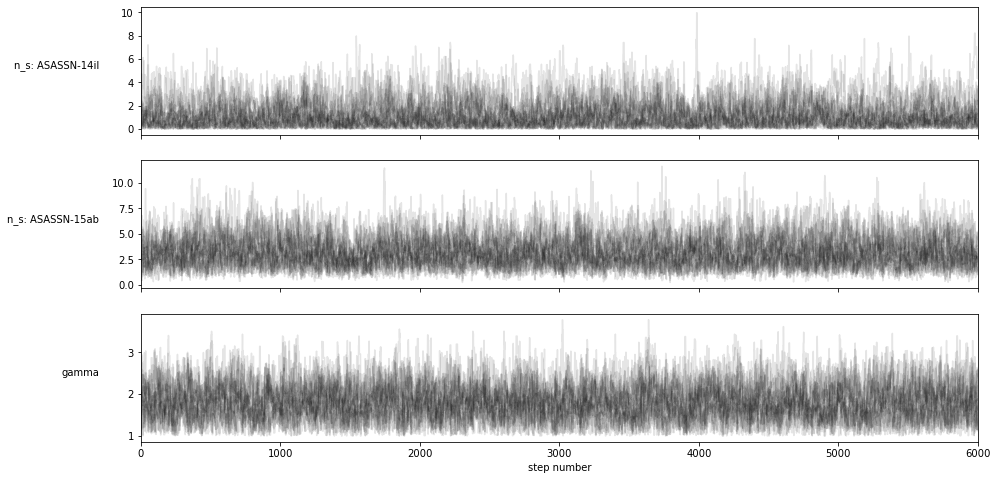

In [29]:
fig, axes = plt.subplots(ndim, figsize=(15, 8), sharex=True)
# samples = sampler.get_chain()
labels= corner_labels
for i in range(ndim):
    ax = axes[i]
    ax.plot(mcmc_pickle[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(mcmc_pickle))
    ax.set_ylabel(labels[i], rotation=0, ha='right')
    ax.yaxis.set_label_coords(-0.05, 0.5)

axes[-1].set_xlabel("step number")
fig.tight_layout

# Save figure to output directory
plt.savefig(os.path.join(plot_output_dir(name), 'walkers.png'))

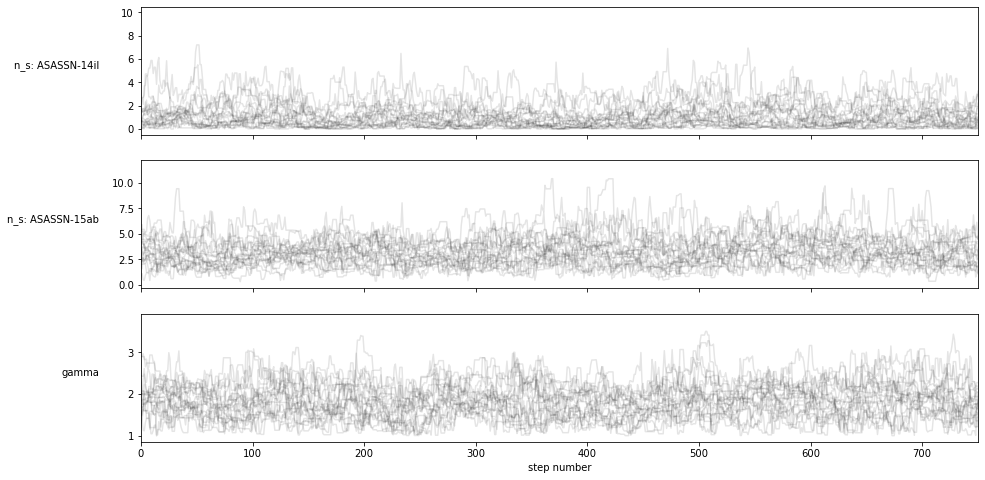

In [30]:
# First n steps
n = 750
fig, axes = plt.subplots(ndim, figsize=(15, 8), sharex=True)
# samples = sampler.get_chain()
labels =  corner_labels
for i in range(ndim):
    ax = axes[i]
    ax.plot(mcmc_pickle[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(mcmc_pickle[:n]))
    ax.set_ylabel(labels[i], rotation=0, ha='right')
    ax.yaxis.set_label_coords(-0.05, 0.5)

axes[-1].set_xlabel("step number")
fig.tight_layout;

### Autocorrelation Function

In [31]:
import emcee.autocorr as eac

In [32]:
eac.function_1d(mcmc_pickle[:,0,2])

array([1.00000000e+00, 9.42748924e-01, 8.90457667e-01, ...,
       1.25675665e-04, 1.30127405e-04, 8.79830921e-05])

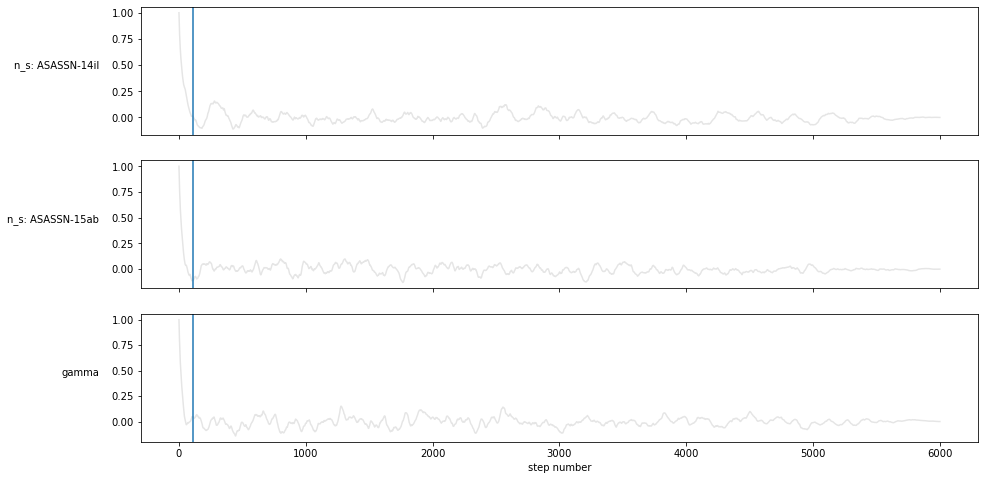

In [33]:
fig, axes = plt.subplots(ndim, figsize=(15, 8), sharex=True)
# samples = sampler.get_chain()
labels = corner_labels
for i in range(ndim):
    ax = axes[i]
    ax.plot(eac.function_1d(mcmc_pickle[:,0,i]), "k", alpha=0.1)
    ax.axvline(3 * eac.integrated_time(mcmc_pickle[:,0,:], quiet=True)[0], 0, 1)
#     ax.set_xlim(0, len(mcmc_pickle[:500]))
    ax.set_ylabel(labels[i], rotation=0, ha='right')
    ax.yaxis.set_label_coords(-0.05, 0.5)

axes[-1].set_xlabel("step number");

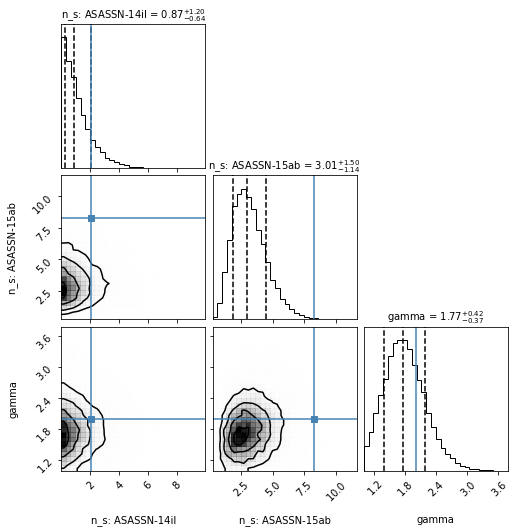

In [34]:
# Corner plots without burn in
n_burnin = 1000
no_burn = mcmc_pickle[n_burnin:].reshape((-1,ndim))

fig = corner.corner(no_burn,
                    labels=corner_labels,
                    quantiles=[0.16, 0.5, 0.84],
                    truths=truths,
                    use_math_text=True,
                    show_titles=True, 
                    title_kwargs={"fontsize": 10},
                    plot_datapoints=False,
                    bins=30)

# Save figure to output directory
plt.savefig(os.path.join(plot_output_dir(name), 'corner.png'))

In [35]:
for i in range(ndim):
    q_16, q_50, q_84 = corner.quantile(no_burn[:,i], [0.16, 0.5, 0.84]) # your x is q_50
    dx_down, dx_up = q_50-q_16, q_84-q_50
    print(f'{i:>3d} {corner_labels[i]:>40s} : {q_50:>7.2f} [{dx_down:<4.2f}, {dx_up:<4.2f}]')

  0                         n_s: ASASSN-14il :    0.87 [0.64, 1.20]
  1                         n_s: ASASSN-15ab :    3.01 [1.14, 1.50]
  2                                    gamma :    1.77 [0.37, 0.42]


In [36]:
nsteps, nwalkers, nparams = mcmc_pickle.shape
acf = np.zeros(shape=(nsteps, nparams))
for i in range(nparams):
    temp = np.zeros(shape=(nsteps, nwalkers))
    for x in range(nwalkers):
        temp[:,x] = eac.function_1d(mcmc_pickle[:,x,i])
    acf[:,i] = temp.mean(axis=1)
    
acf

array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 9.52767837e-01,  9.47227540e-01,  9.46662918e-01],
       [ 9.09910097e-01,  8.99764395e-01,  8.98389258e-01],
       ...,
       [-1.92575287e-04, -1.06059418e-04, -4.87679978e-05],
       [-1.33626784e-04, -8.86737661e-05, -3.35454242e-05],
       [-5.69090505e-05, -3.95754753e-05, -1.27428908e-05]])

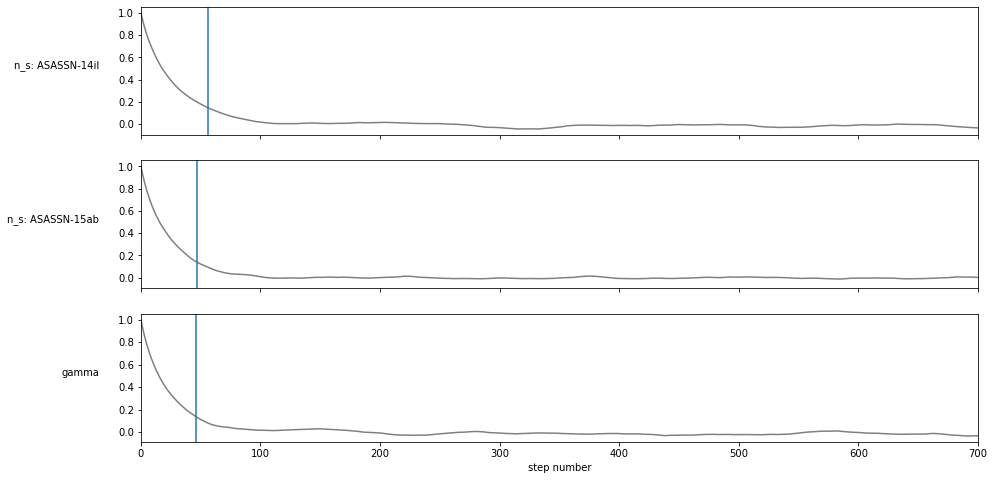

In [37]:
# First n steps
n = 700
fig, axes = plt.subplots(ndim, figsize=(15, 8), sharex=True)
# samples = sampler.get_chain()
labels = corner_labels
act = eac.integrated_time(mcmc_pickle[:,:,:], quiet=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(acf[:,i], "k", alpha=0.5)
    ax.axvline(act[i], 0, 1)
    ax.set_xlim(0, len(mcmc_pickle[:n]))
    ax.set_ylabel(labels[i], rotation=0, ha='right')
    ax.yaxis.set_label_coords(-0.05, 0.5)

axes[-1].set_xlabel("step number");